In [1]:
!pip install wbdata


import wbdata
import pandas as pd

  Using cached wbdata-0.3.0-py3-none-any.whl (14 kB)


# Overview: Population Trends of India: 1960 - Present

In [2]:
# Data from WDI on age-sex comes in the forms of variables
# which take the form "SP.POP.LLHH.MA" for males
# and "SP.POP.LLHH.FE" for females, where LL is the *low* end of
# age range, like "05" for 5-yo, and HH is the *high* end.

# We construct a list of age-ranges.

# Start with an empty list of age-rages
age_ranges = []
a = [1, 2, 3]
# Ranges top out at 80, and go in five year increments
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")

print(age_ranges)

['0004', '0509', '1014', '1519', '2024', '2529', '3034', '3539', '4044', '4549', '5054', '5559', '6064', '6569', '7074', '7579', '80UP']


In [3]:
male_variables = {"SP.POP."+age_range+".MA":"males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"females "+age_range for age_range in age_ranges}

variables = male_variables
variables.update(female_variables)

print(variables)

{'SP.POP.0004.MA': 'males 0004', 'SP.POP.0509.MA': 'males 0509', 'SP.POP.1014.MA': 'males 1014', 'SP.POP.1519.MA': 'males 1519', 'SP.POP.2024.MA': 'males 2024', 'SP.POP.2529.MA': 'males 2529', 'SP.POP.3034.MA': 'males 3034', 'SP.POP.3539.MA': 'males 3539', 'SP.POP.4044.MA': 'males 4044', 'SP.POP.4549.MA': 'males 4549', 'SP.POP.5054.MA': 'males 5054', 'SP.POP.5559.MA': 'males 5559', 'SP.POP.6064.MA': 'males 6064', 'SP.POP.6569.MA': 'males 6569', 'SP.POP.7074.MA': 'males 7074', 'SP.POP.7579.MA': 'males 7579', 'SP.POP.80UP.MA': 'males 80UP', 'SP.POP.0004.FE': 'females 0004', 'SP.POP.0509.FE': 'females 0509', 'SP.POP.1014.FE': 'females 1014', 'SP.POP.1519.FE': 'females 1519', 'SP.POP.2024.FE': 'females 2024', 'SP.POP.2529.FE': 'females 2529', 'SP.POP.3034.FE': 'females 3034', 'SP.POP.3539.FE': 'females 3539', 'SP.POP.4044.FE': 'females 4044', 'SP.POP.4549.FE': 'females 4549', 'SP.POP.5054.FE': 'females 5054', 'SP.POP.5559.FE': 'females 5559', 'SP.POP.6064.FE': 'females 6064', 'SP.POP.6569.

# Population Functions

In [40]:
def population(year, sex, age_group, country):
    
    country_label = wbdata.search_countries(country)[0]['id']

    df = wbdata.get_dataframe(variables,country=country_label).loc[[str(year)]]

    age_group = list(age_group)
    if age_group[1] > 80:
        age_group[1] = 80
    # for males
    if sex == 'male':
        start_idx = age_group[0] // 5
        end_idx = age_group[1] // 5 + 1
        
        df2 = df.iloc[:, start_idx:end_idx]
        
    # for females
    if sex == 'female':
        start_idx = age_group[0] // 5 + len(df.columns)//2
        end_idx = age_group[1] // 5 + 1 + len(df.columns)//2
        df2 = df.iloc[:, start_idx:end_idx]

    if sex == 'people':
        start_idx_m = age_group[0] // 5
        end_idx_m = age_group[1] // 5 + 1
        start_idx_f = age_group[0] // 5 + len(df.columns)//2
        end_idx_f = age_group[1] // 5 + 1 + len(df.columns)//2

        df2 = df.iloc[:, start_idx_m:end_idx_m]
        df3 = df.iloc[:, start_idx_f:end_idx_f]
          
    if len(df2.columns) == 1:
        df2.iloc[0, 0] = df2.iloc[0, 0] / 5 * (age_group[1]-age_group[0]+1)
    else:
        lower_gap = age_group[0] % 5
        upper_gap = age_group[1] % 5
        df2.iloc[0, 0] = df2.iloc[0, 0] / 5 * (5-lower_gap)
        df2.iloc[0, -1] = df2.iloc[0, -1] / 5 * (upper_gap + 1)
    
    if sex == 'people':
        if len(df3.columns) == 1:
            df3.iloc[0, 0] = df3.iloc[0, 0] / 5 * (age_group[1]-age_group[0]+1)
        else:
            df3.iloc[0, 0] = df3.iloc[0, 0] / 5 * (5-lower_gap)
            df3.iloc[0, -1] = df3.iloc[0, -1] / 5 * (upper_gap + 1)
        df2 = df2.join(df3)
    
    sum = df2.sum(axis='columns')[0]
    
    return sum
    

In [41]:
# test
# this function assumes that population is evenly distributed within each five-year age interval.
df = population(year = 2020, sex = 'people', age_group = (9,10) , country = 'India')
df

49581071.0

In [9]:
def population_df(year, country):
    
    country_label = wbdata.search_countries(country)[0]['id']

    df = wbdata.get_dataframe(variables,country=country_label).loc[[str(year)]]
    df = df.transpose()
    # transform dataframe
    pop_df = pd.DataFrame({'Country': country,'Year': year,'Age Range': age_ranges,
        'Male': df.iloc[0:int(len(df)/2),0].tolist(), 'Female': df.iloc[int(len(df)/2):len(df),0].tolist()})
    pop_df['Total'] = pop_df['Male'] + pop_df['Female']
    return pop_df

In [10]:
# test
pop_df = population_df(year=2000, country='France')
pop_df

,Country,Year,Age Range,Male,Female,Total
0,France,2000,0004,1909500.0,1817413.0,3726913.0
1,France,2000,0509,1906038.0,1816368.0,3722406.0
2,France,2000,1014,2022498.0,1929786.0,3952284.0
3,France,2000,1519,2062243.0,1983172.0,4045415.0
4,France,2000,2024,1958209.0,1930689.0,3888898.0
5,France,2000,2529,2146517.0,2149435.0,4295952.0
6,France,2000,3034,2162080.0,2182337.0,4344417.0
7,France,2000,3539,2202826.0,2246159.0,4448985.0
8,France,2000,4044,2152835.0,2211442.0,4364277.0
9,France,2000,4549,2154636.0,2197595.0,4352231.0


# Population Pyramids

In [11]:
# visualize population pyramid
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np

py.init_notebook_mode(connected=True)


# get population dataframe
pop_df = population_df(year=2010, country='India')

# specify layout
layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))

bins = [go.Bar(x = pop_df['Male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),
        go.Bar(x = -pop_df['Female'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip'
               )
       ]

fig = go.Figure(data=bins, layout=layout)

#fig.update_layout(xaxis_tickformat = '%')
fig.show()

In [12]:
# create initial plot
year_init = 1960
# get population dataframe
pop_df = population_df(year=year_init, country='India')

# specify layout
layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'),
                  title_text=f"Population Pyramind Animation")

bins = [go.Bar(x = pop_df['Male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),
        go.Bar(x = -pop_df['Female'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip'
               )
       ]

#fig = go.Figure(data=bins, layout=layout)

#fig.show()

years = range(1960,2030,10)

frames = []
for y in years:
    
    # get population dataframe
    pop_df = population_df(year=y, country='India')

    # update the bins
    bins = [go.Bar(x = pop_df['Male'],
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Men',
                   marker=dict(color='purple'),
                   hoverinfo='skip'
                   ),
            go.Bar(x = -pop_df['Female'],
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Women',
                   marker=dict(color='pink'),
                   hoverinfo='skip'
                   )
            ]
    # create the button
    button = {
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 1000}}],
            }
        ],
    }
    layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'), updatemenus=[button], 
                    title_text=f"Population Pyramind Animation")
    
    # create frames
    frame = go.Frame(data=bins, layout=go.Layout(title_text=f"Population Pyramind in Year {y}"))
    frames.append(frame)
    


fig = go.Figure(data=bins,
                frames=frames,
                layout = layout)
                                 
# show animation
fig.show()

In [13]:
import cufflinks as cf

variable_labels = {"SP.POP.TOTL":"World Population"}

IND_DATA = wbdata.get_dataframe(variable_labels, country="IND")

# Date index is of type string; change to integers
IND_DATA.index = IND_DATA.index.astype(int)

cf.go_offline()

IND_DATA.index = IND_DATA.index.astype(int)
IND_DATA.head()

IND_DATA.iplot(title="Population Growth in India",yTitle='Population',xTitle='Year')


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



# Population Growth and Agricultural Production

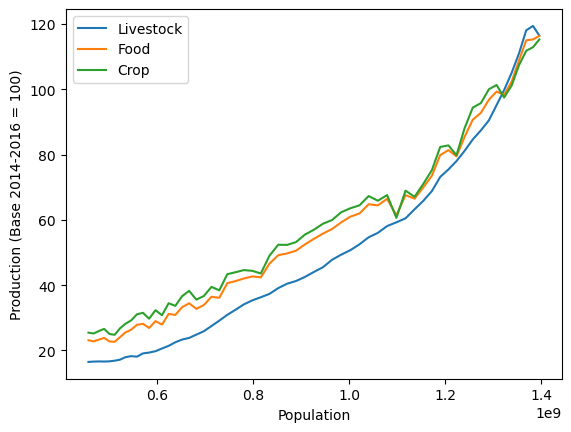

In [20]:
#wbdata.get_indicator()
"""
Agriculture Production Indices:

AG.PRD.AGRI.XD                                     Agriculture production index (1999-2001 = 100)
AG.PRD.BLY.MT                                      Barley production (metric tons)
AG.PRD.CREL.MT                                     Cereal production (metric tons)
AG.PRD.CREL.XD                                     Cereal production index (1999-2001 = 100)
AG.PRD.CROP.XD                                     Crop production index (2014-2016 = 100)
AG.PRD.FNO.MT                                      Fonio production (metric tons)
AG.PRD.FOOD.XD                                     Food production index (2014-2016 = 100)
AG.PRD.GAGRI.XD                                    Agriculture production index (gross, 1999-2001 = 100)
AG.PRD.GCREL.XD                                    Cereal production index (gross, 1999-2001 = 100)
AG.PRD.GCROP.XD                                    Crop production index (gross, 1999-2001 = 100)
AG.PRD.GFOOD.XD                                    Food production index (gross, 1999-2001 = 100)
AG.PRD.GLVSK.XD                                    Livestock production index (gross, 1999-2001 = 100)
AG.PRD.GNFOOD.XD                                   Non-food production index (gross, 1999-2001 = 100)
AG.PRD.LVSK.XD                                     Livestock production index (2014-2016 = 100)
AG.PRD.MLT.MT                                      Millet production (metric tons)
AG.PRD.MZE.MT                                      Maize production (metric tons)
AG.PRD.NFOOD.XD                                    Gross non-food production index (1999-2001 = 100)
AG.PRD.RICE.MT                                     Rice production (metric tons)
AG.PRD.RTTB.MT                                     Roots and tubers production (metric tons)
AG.PRD.SGM.MT                                      Sorghum production (metric tons)
AG.PRD.WHT.MT                                      Wheat production (metric tons)
"""

vars = {"AG.PRD.LVSK.XD":"Livestock index",
        "AG.PRD.FOOD.XD":"Food index",
        "AG.PRD.CROP.XD":"Crop index",
        "SP.POP.TOTL":"Population"}


ag = wbdata.get_dataframe(vars,country='IND')
ag = ag.reset_index()
ag['date'] = ag['date'].astype(int)

lvsk = plt.plot('Population', 'Livestock index', data=ag, label='Livestock')
food = plt.plot('Population', 'Food index', data=ag, label='Food')
crop = plt.plot('Population', 'Crop index', data=ag, label='Crop')
plt.xlabel('Population')
plt.ylabel('Production (Base 2014-2016 = 100)')
plt.legend()

Text(0, 0.5, 'Food Production (log)')

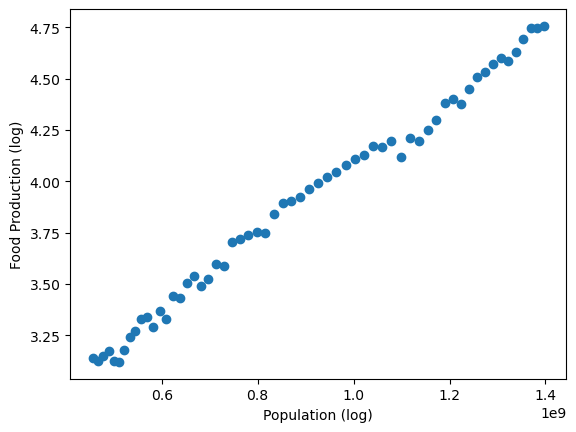

In [23]:
ag_idx = ag.set_index(ag['date']).drop(columns=['date'])
ag_idx['Food index (log)'] = np.log(ag_idx['Food index'])
#ag_idx_log = np.log(ag_idx).dropna()
plt.scatter('Population', 'Food index (log)', data=ag_idx)
plt.xlabel('Population (log)')
plt.ylabel('Food Production (log)')

In [24]:
import plotly.express as px

#plt.plot(ag['date'], np.log(ag['Population']))
#plt.plot(ag['date'], ag['Food index'])
ag_idx = ag.set_index(ag['date']).drop(columns=['date'])
ag_asc = ag_idx.sort_index()
rates = np.log(ag_asc).diff().dropna()
#rates
px.scatter(rates, 
           x=rates.index, 
           y=['Population', 'Food index'], 
           labels={
               'value': 'Growth Rate (per year)',
               'date': 'Year'
           },
           title='Growth Rate of Food versus Population over Time',
           trendline='ols')#, data=pop_growth_rate)
#px.scatter(rates, x=rates.index, y='Food index', trendline='ols')#, data=pop_growth_rate)

# Slow Down of Population Growth and Expansion of Women's Education

In [14]:
def growth_df(region):
    df=wbdata.get_dataframe({'SP.POP.GROW': 'Total Population growth (annual %)',
                            'SP.RUR.TOTL.ZG': 'Rural population growth (annual %)',
                            'SP.URB.GROW': 'Urban population growth (annual %)'}, country=region)
    df.index = df.index.rename('year')
    df.index = df.index.astype(int)
    return df

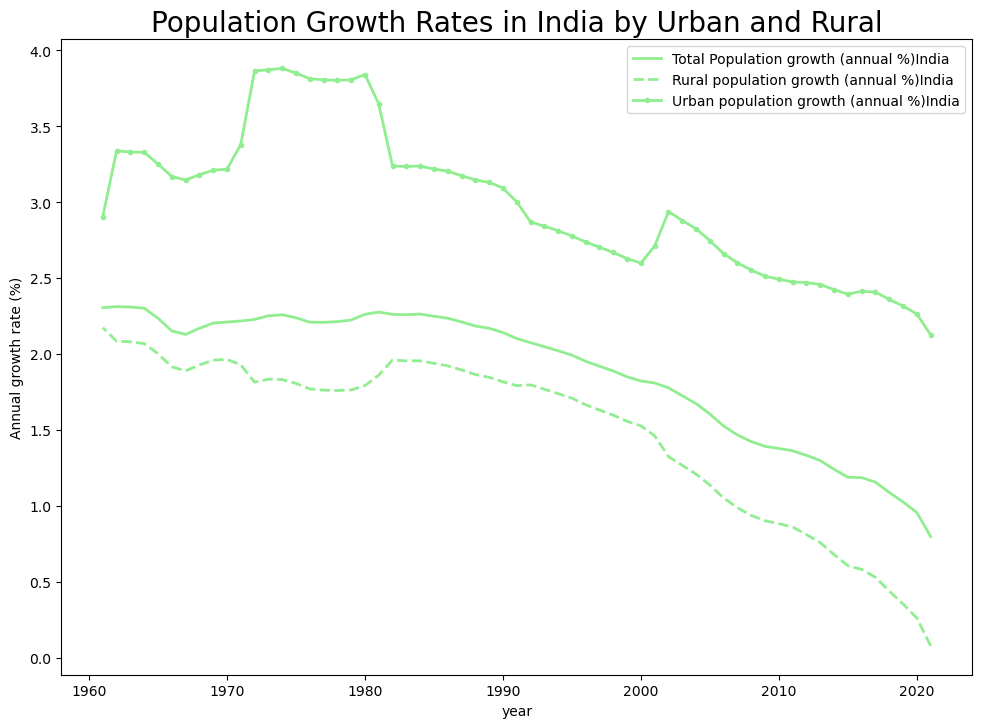

In [25]:
import matplotlib.pyplot as plt

ind_gr = growth_df('IND')
def urb_rur_plot(df, India, color):
    fig = plt.figure(figsize=(11.75, 8.25))
    ax = plt.axes() 
     
    plt.plot(ind_gr.index, ind_gr.iloc[:, 0],  color='lightgreen',linewidth=2)
    plt.plot(ind_gr.index, ind_gr.iloc[:, 1],  '--', color='lightgreen',linewidth=2)
    plt.plot(ind_gr.index, ind_gr.iloc[:, 2],  '.-', color='lightgreen', linewidth=2);
    ax.legend((df.columns+India).append(ind_gr.columns))

    plt.title('Population Growth Rates in India by Urban and Rural', {'fontsize': 20})
    plt.xlabel('year')
    plt.ylabel('Annual growth rate (%)')

urb_rur_plot(ind_gr, "India", 'green')

In [18]:
IND_Birth_Death = wbdata.get_dataframe({'SP.DYN.CBRT.IN': 'Birth rate % (per 1,000 people)',
                            'SP.DYN.CDRT.IN': 'Death rate % (per 1,000 people)'}, country="IND")
                                       
IND_Birth_Death.index = IND_Birth_Death.index.rename('year')
IND_Birth_Death.index = IND_Birth_Death.index.astype(int)   
IND_Birth_Death.iplot(title="Birth and Death Rates in India",yTitle='Population',xTitle='Year')

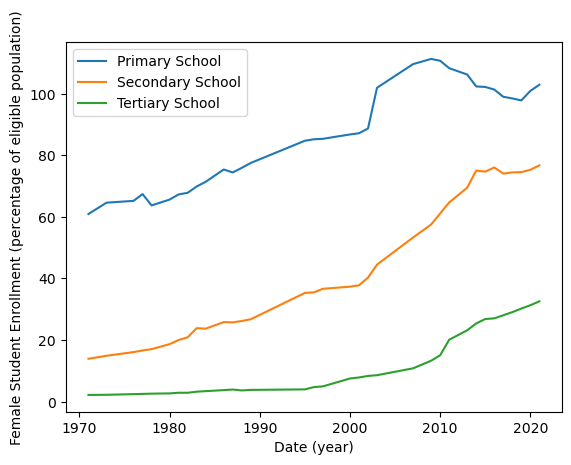

In [27]:
#wbdata.get_indicator()
"""
School Enrollment Indices:

SE.PRM.ENRR.FE                        Female Primary School Enrollment
SE.SEC.ENRR.FE                        Female Secondary School Enrollment
SE.TER.ENRR.FE                        Female Tertiary School Enrollment
"""

vars = {"SE.PRM.ENRR.FE":"Female Primary School Enrollment",
        "SE.SEC.ENRR.FE":"Female Secondary School Enrollment",
        "SE.TER.ENRR.FE":"Female Tertiary School Enrollment"}


se_com = wbdata.get_dataframe(vars,country='IND')
se_com = se_com.reset_index()
se_com['date'] = se_com['date'].astype(int)
se_com = se_com.dropna()
#print(se_com)

se_com_pr = plt.plot('date', 'Female Primary School Enrollment', data=se_com, label='Primary School')
se_com_sec = plt.plot('date', 'Female Secondary School Enrollment', data=se_com, label='Secondary School')
se_com_ter = plt.plot('date', 'Female Tertiary School Enrollment', data=se_com, label='Tertiary School')
plt.xlabel('Date (year)')
plt.ylabel('Female Student Enrollment (percentage of eligible population)')
plt.legend()
#plt.legend(['Primary Enrollment', 'Secondary Enrollment', 'Tertiary Enrollment'])

Text(0, 0.5, 'Population (log)')

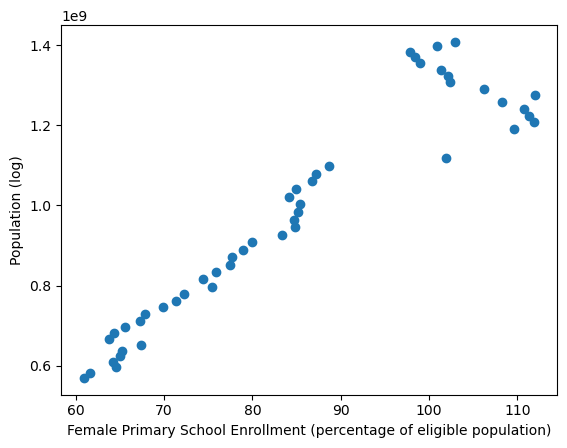

In [23]:
se_pr_idx = se_pr.set_index(se_pr['date']).drop(columns=['date'])
se_pr_asc = se_pr_idx.sort_index()
ag_fdix = ag_idx
se_pr_ag_merge = pd.merge(ag_fdix, se_pr_idx, on= "date")

plt.scatter('Female Primary School Enrollment', 'Population', data=se_pr_ag_merge)
plt.xlabel('Female Primary School Enrollment (percentage of eligible population)')
plt.ylabel('Population (log)')

Text(0, 0.5, 'Population (log)')

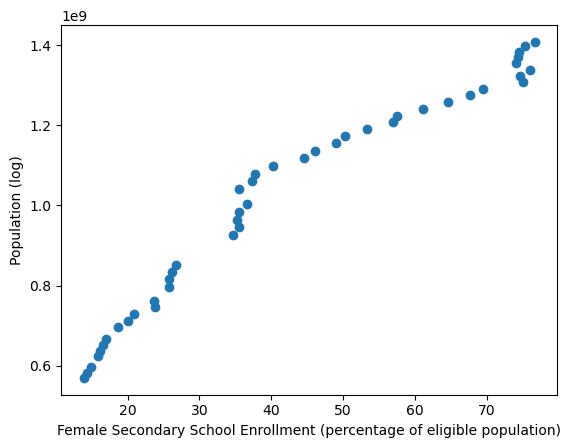

In [25]:
se_sec_idx = se_sec.set_index(se_sec['date']).drop(columns=['date'])
se_sec_asc = se_sec_idx.sort_index()
ag_fdix = ag_idx
se_sec_ag_merge = pd.merge(ag_fdix, se_sec_idx, on= "date")

plt.scatter('Female Secondary School Enrollment', 'Population', data=se_sec_ag_merge)
plt.xlabel('Female Secondary School Enrollment (percentage of eligible population)')
plt.ylabel('Population (log)')

Text(0, 0.5, 'Population (log)')

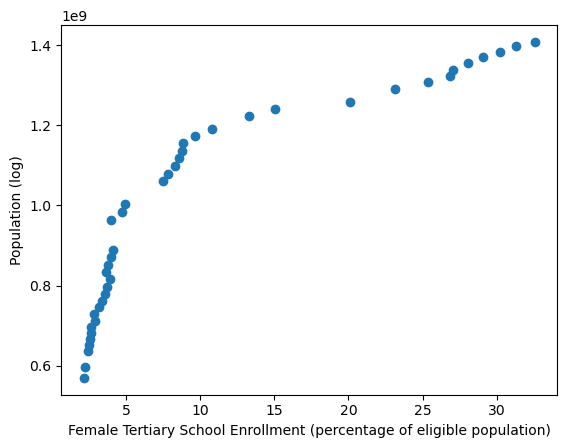

In [29]:
se_ter_idx = se_ter.set_index(se_ter['date']).drop(columns=['date'])
se_ter_asc = se_ter_idx.sort_index()
ag_fdix = ag_idx
se_ter_ag_merge = pd.merge(ag_fdix, se_ter_idx, on= "date")

plt.scatter('Female Tertiary School Enrollment', 'Population', data=se_ter_ag_merge)
plt.xlabel('Female Tertiary School Enrollment (percentage of eligible population)')
plt.ylabel('Population (log)')

In [28]:
vars = {
    "SP.DYN.TFRT.IN": "Total Fertility Rate",
    "SE.PRM.ENRR.FE": "Primary",
    "SE.SEC.ENRR.FE": "Secondary",
    "SE.TER.ENRR.FE": "Tertiary"
}

school = wbdata.get_dataframe(vars,country='IND').dropna().sort_index()

px.scatter(school, 
           x="Total Fertility Rate", 
           y=["Primary",
              "Secondary",
              "Tertiary"
             ], 
           labels={
               'value': 'Enrollment (Female, % Gross)'
           },
           title='Total Fertility Rate versus School Enrollment',
           # adjust trendline and trendline_options as necessary
           trendline="lowess",
           trendline_options=dict(frac=0.3)
          )
#school
#plt.scatter('Total Fertility Rate', 'Secondary School Enrollment (Female, % Gross)', data=school)
#plt.title('Total Fertility Rate versus Secondary School Enrollment')
#plt.xlabel('Total Fertility Rate')
#plt.ylabel('Secondary School Enrollment (Female, % Gross)')